In [1]:
import numpy as np
from astropy.io import fits
from scipy import ndimage
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set(style="white", palette="muted", color_codes=True)
%config InlineBackend.figure_format = 'retina'
%load_ext lab_black

# Read File

In [2]:
fits_image_filename = "test_back/star031139.fits"
with fits.open(fits_image_filename) as hdul:
    hdul.info()
    header = hdul[0].header
    data = hdul[0].data

Filename: test_back/star031139.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (300, 300)   float64   


In [3]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  300                                                  
NAXIS2  =                  300                                                  
EXTEND  =                    T                                                  

In [4]:
data.shape

(300, 300)

# Plot

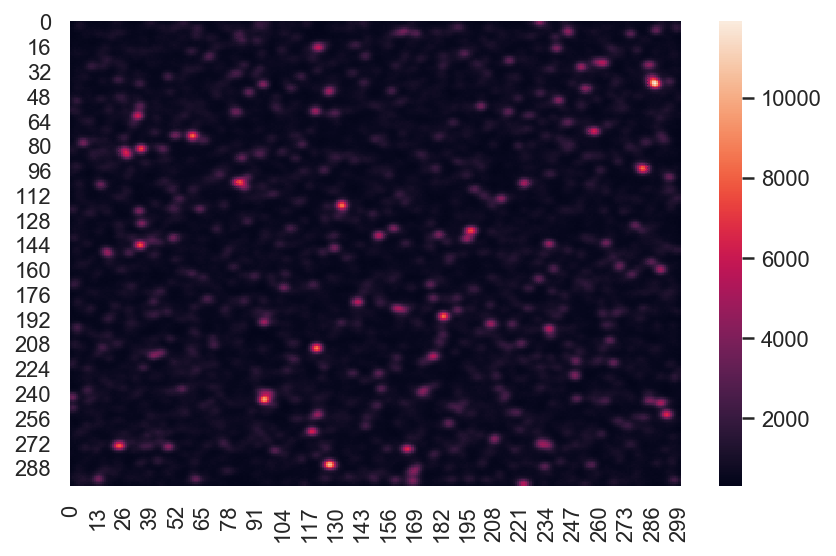

In [5]:
sns.heatmap(data)
plt.tight_layout()

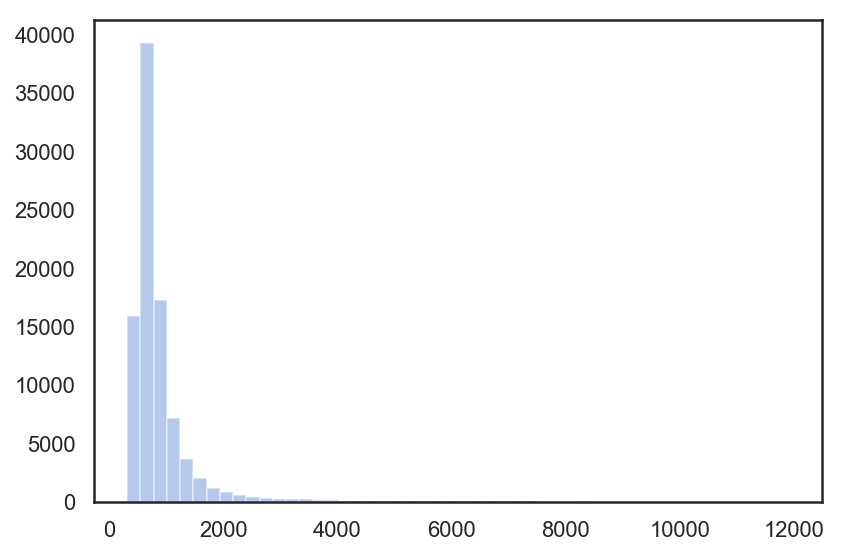

In [6]:
sns.distplot(data.reshape(1, -1)[0], kde=False)
plt.tight_layout()

# σ-clip

剔除超过 n 倍 σ 的值，反复迭代至所有数值皆落在区间内。注：所有都以中位数代替均值。

In [7]:
def sigma_clip(data, n):
    def clip(data, n):
        median = np.median(data)
        sigma = np.std(data)
        return data[(data > median - n * sigma) & (data < median + n * sigma)]

    while True:
        new_data = clip(data, n)
        if new_data.all() == data.all():
            break
        data = new_data
    return new_data

median: 698.2188281621042
 sigma: 335.0959052411149


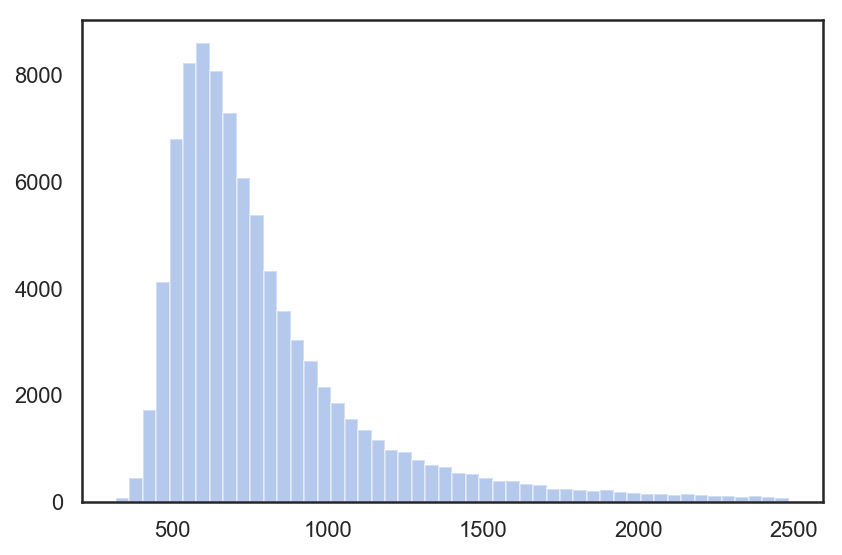

In [8]:
new_data = sigma_clip(data, 3)
print("median:", np.median(new_data))
print(" sigma:", np.std(new_data))
sns.distplot(new_data.reshape(1, -1)[0], kde=False)
plt.tight_layout()

median: 692.5298231432154
 sigma: 278.03687849901235


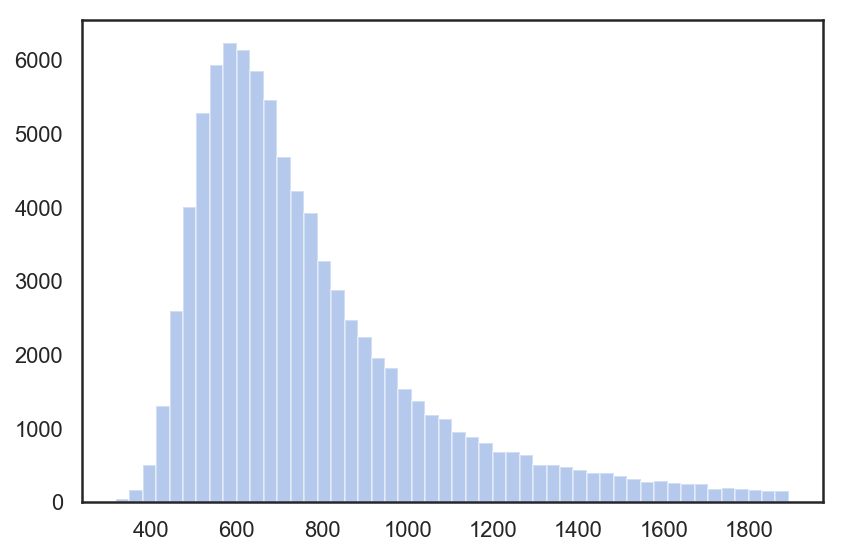

In [9]:
new_data = sigma_clip(data, 2)
print("median:", np.median(new_data))
print(" sigma:", np.std(new_data))
sns.distplot(new_data.reshape(1, -1)[0], kde=False)
plt.tight_layout()

median: 687.138705581745
 sigma: 242.45936582011763


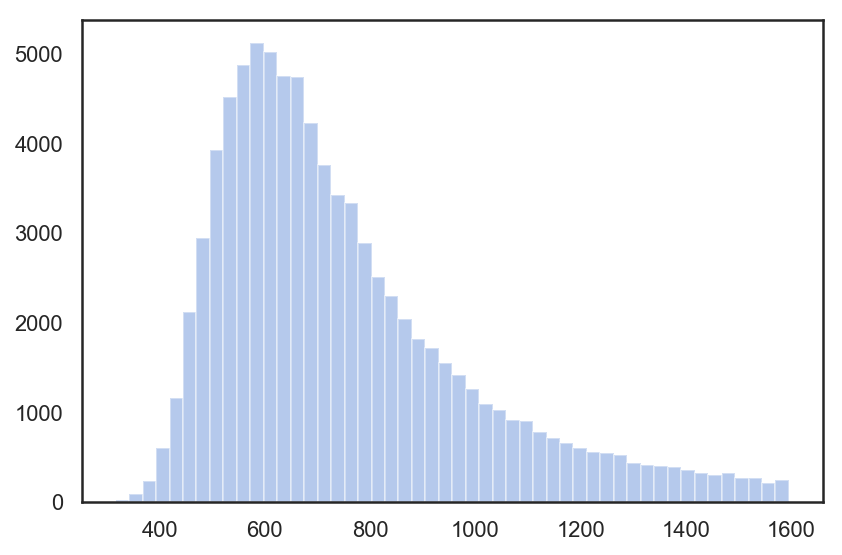

In [10]:
new_data = sigma_clip(data, 1.5)
print("median:", np.median(new_data))
print(" sigma:", np.std(new_data))
sns.distplot(new_data.reshape(1, -1)[0], kde=False)
plt.tight_layout()

# Mode = a * Median - b * Mean

In [11]:
mode = lambda data, a, b: a * np.median(data) - b * np.mean(data)

In [12]:
mode(new_data, 3, 2)

559.7349054500007

In [13]:
mode(new_data, 2.5, 1.5)

591.5858554829367

# Combine

In [14]:
def main(fits_image_filename):
    with fits.open(fits_image_filename) as hdul:
        data = hdul[0].data
    new_data = sigma_clip(data, 3)

    f, axes = plt.subplots(1, 3, figsize=(20, 5))
    sns.heatmap(data, ax=axes[0])
    sns.distplot(data.reshape(1, -1)[0], kde=False, ax=axes[1])
    sns.distplot(new_data.reshape(1, -1)[0], kde=False, ax=axes[2])
    print("median:", np.median(new_data))
    print("mode:", mode(new_data, 2.5, 1.5))

median: 303.77418131846355
mode: 300.2539680549782


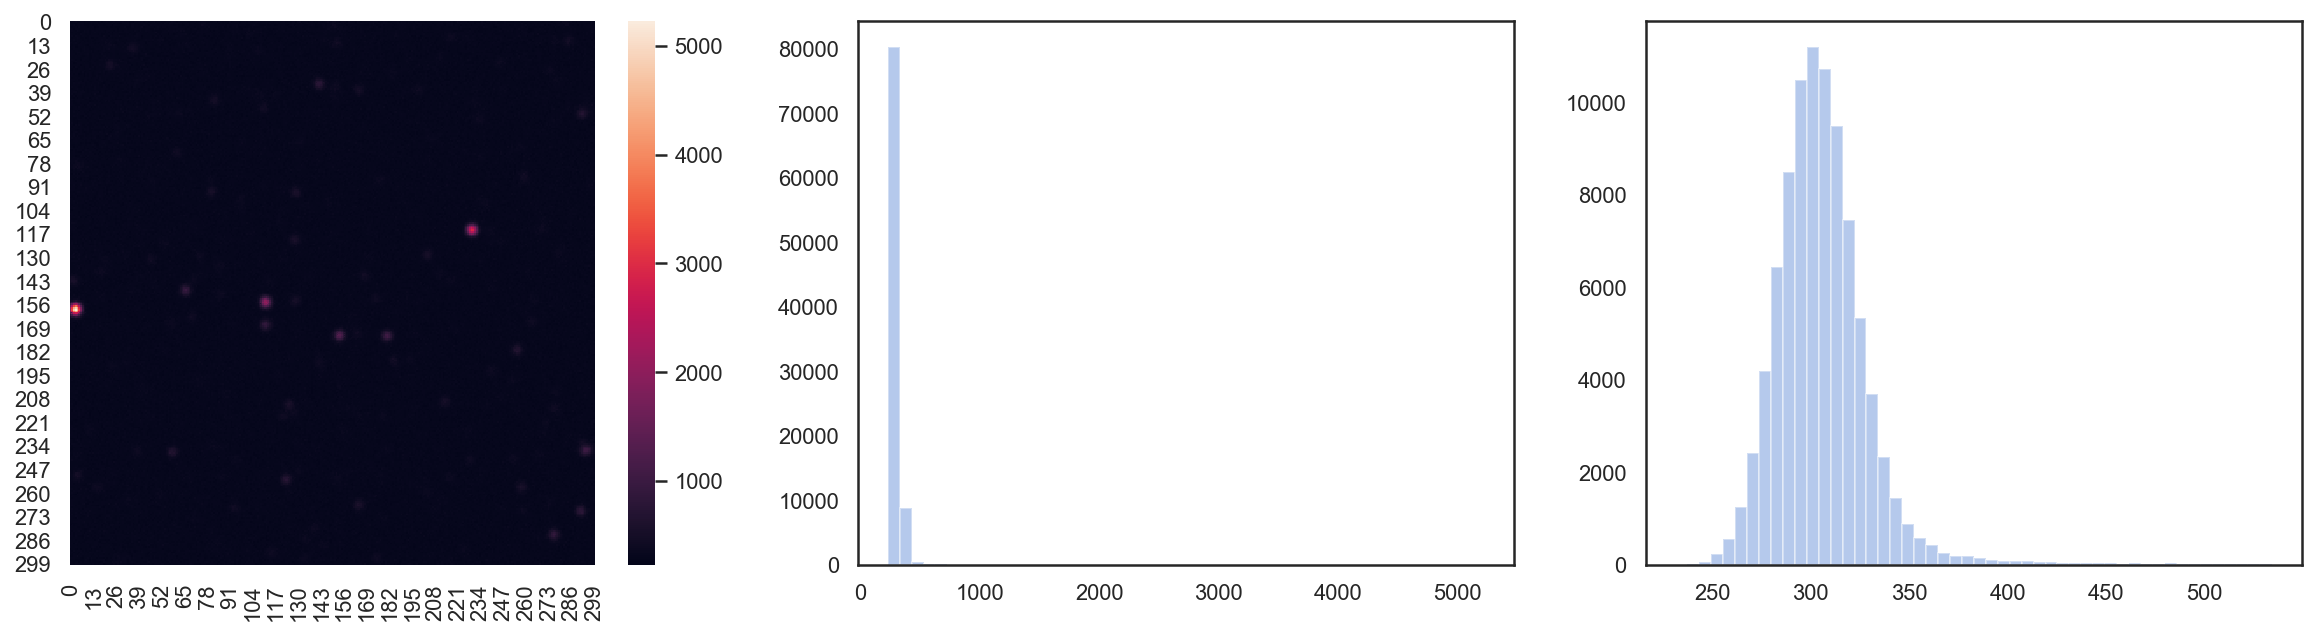

In [15]:
main("test_back/star000569.fits")

median: 309.6911890511962
mode: 300.077988514361


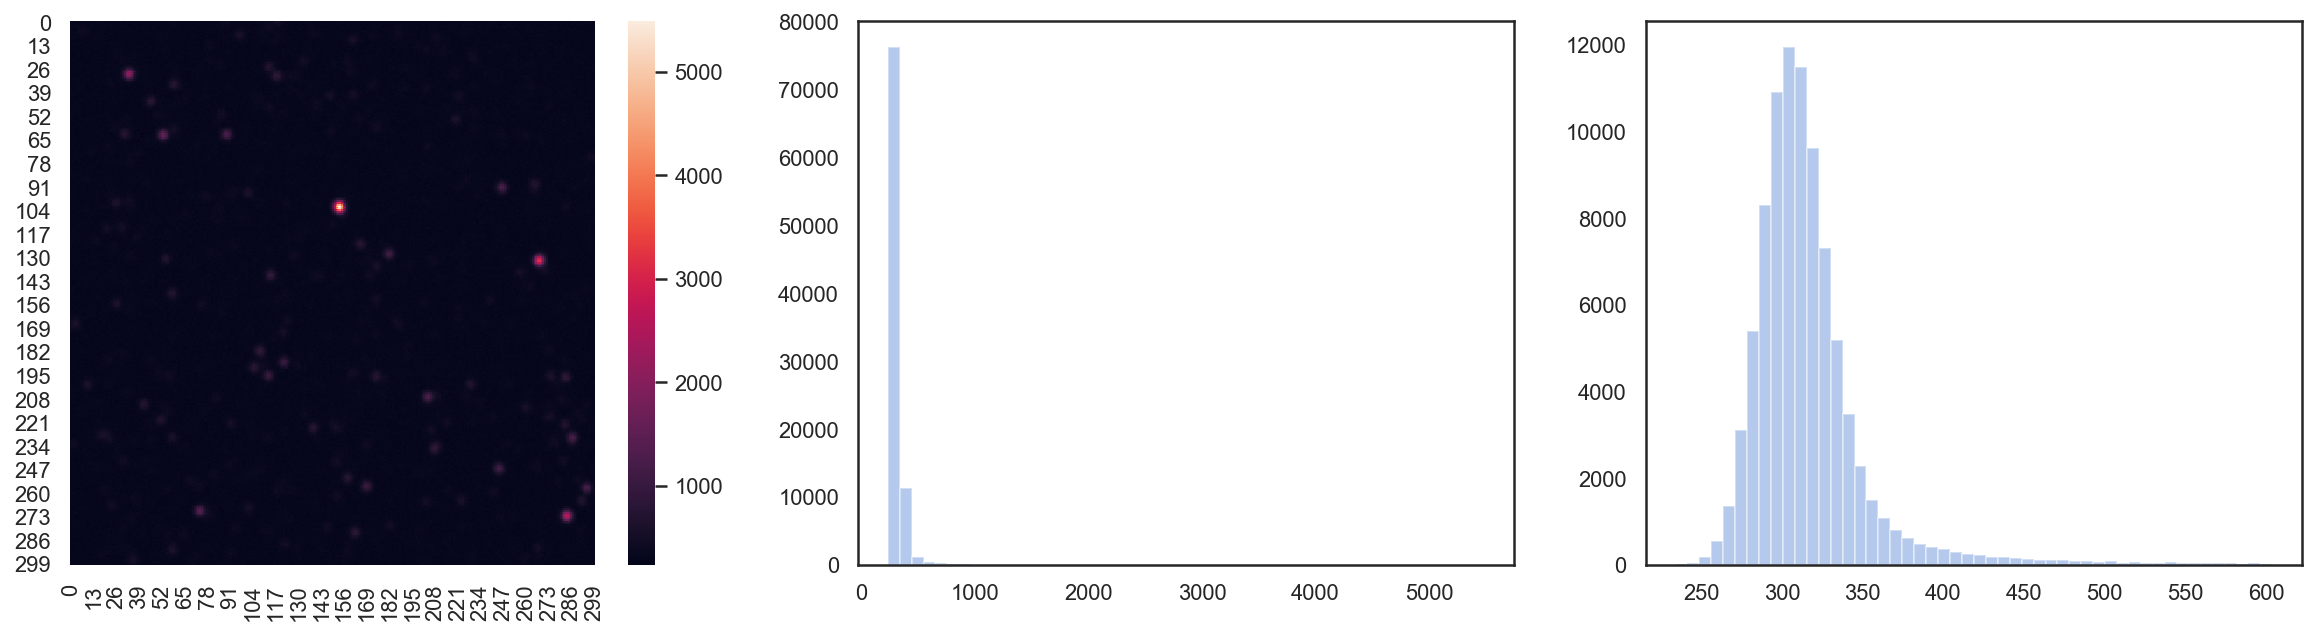

In [16]:
main("test_back/star001334.fits")

median: 332.72602820694374
mode: 302.9672243204525


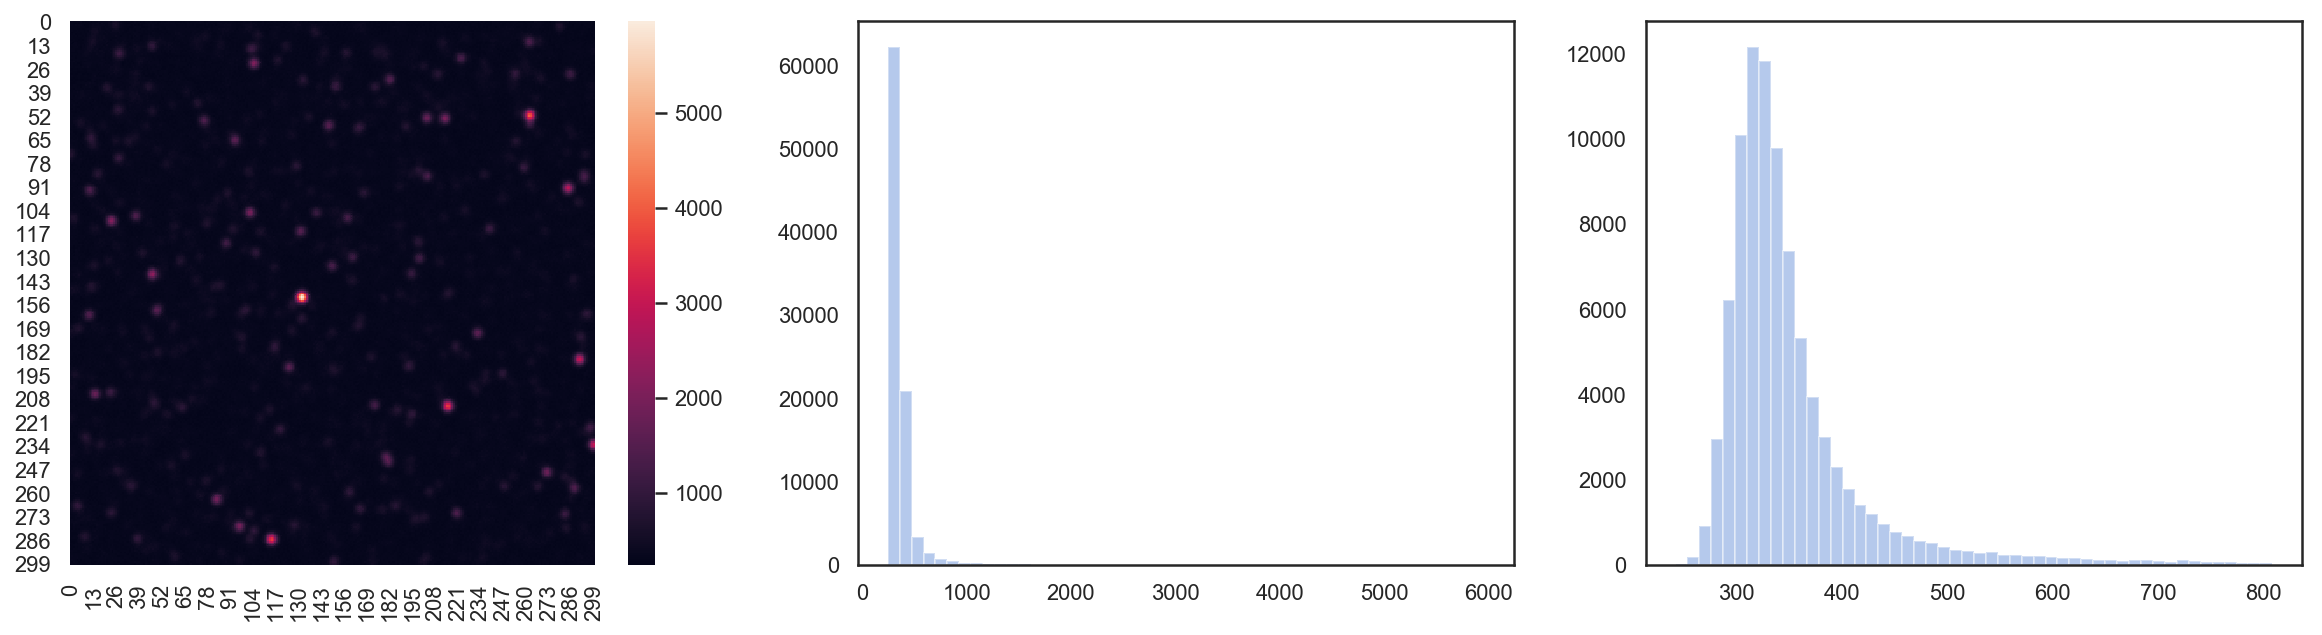

In [17]:
main("test_back/star003904.fits")

median: 391.15375799304184
mode: 321.74578881789444


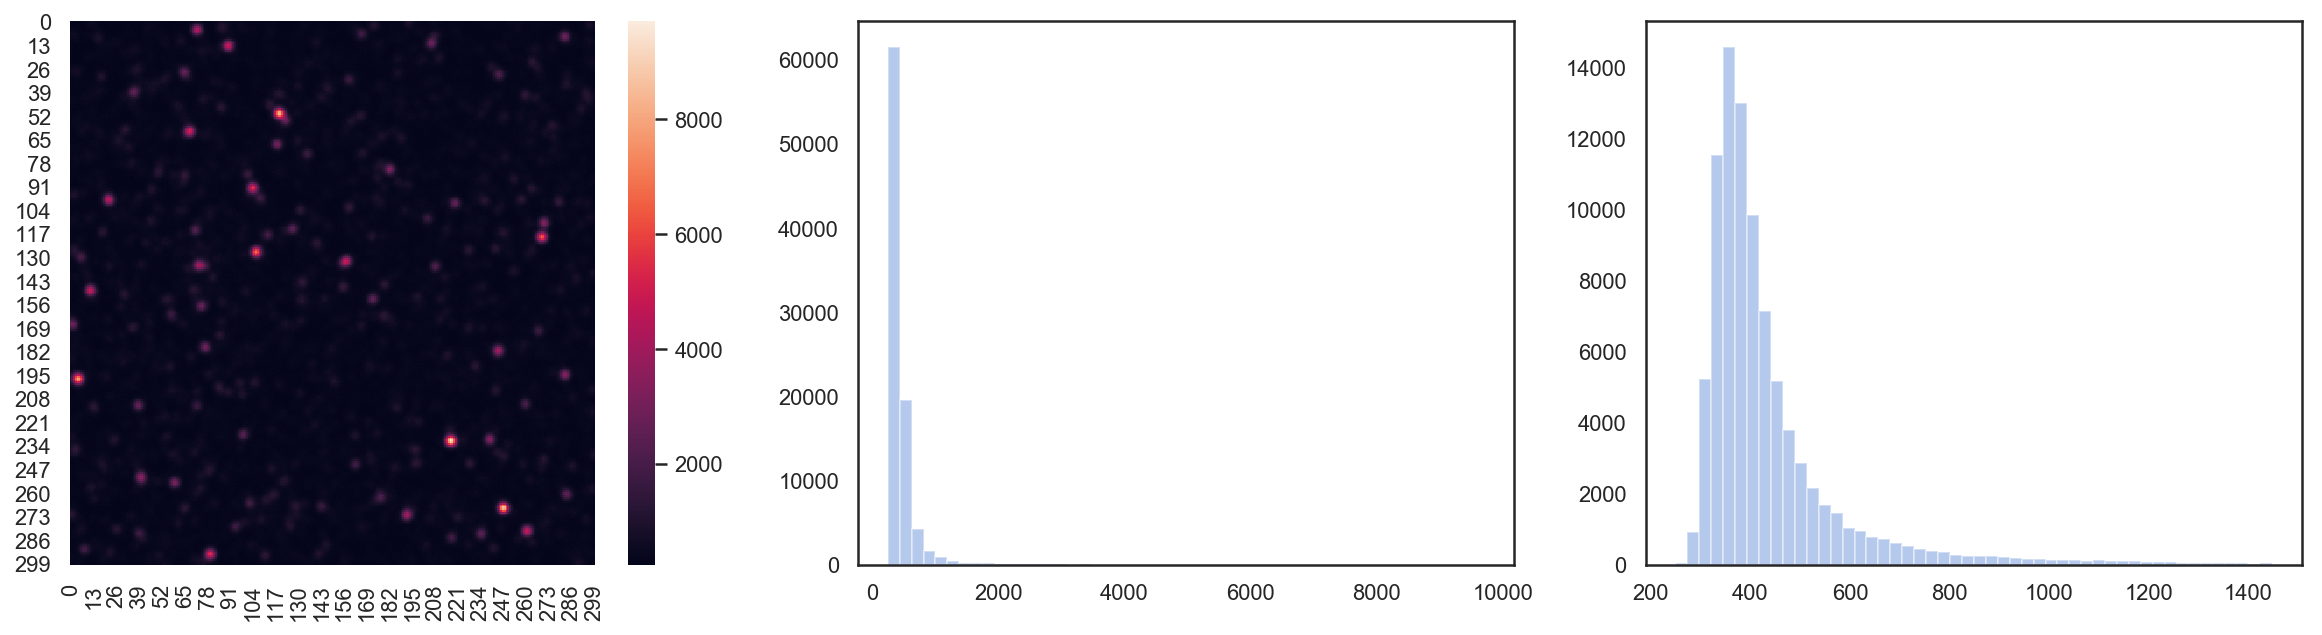

In [18]:
main("test_back/star009188.fits")

median: 698.2188281621042
mode: 548.3374410489291


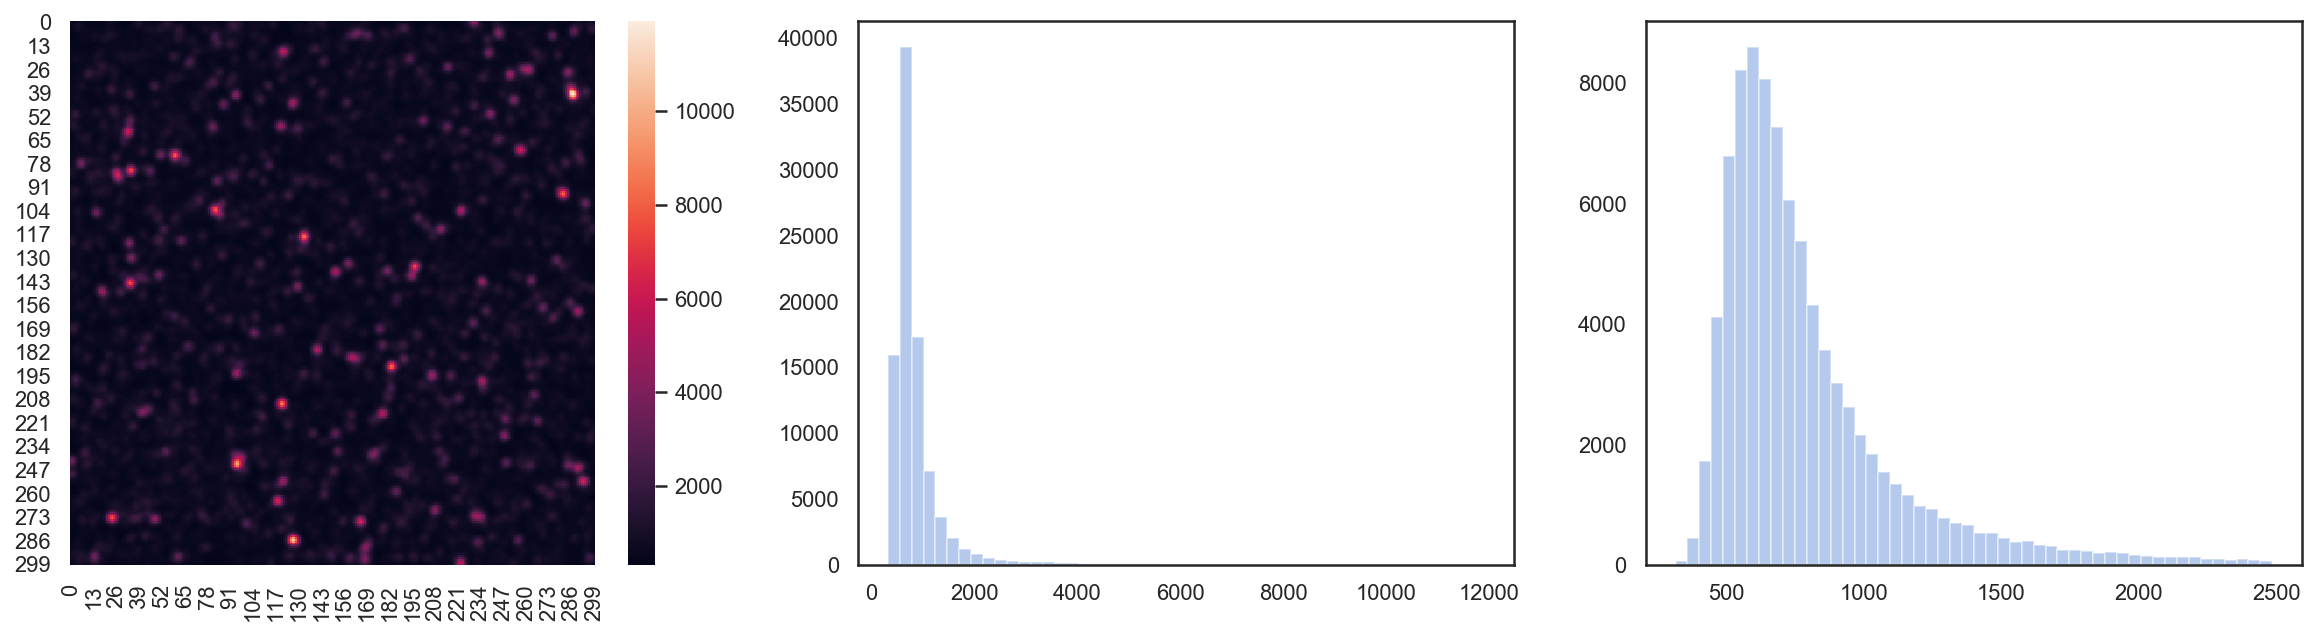

In [19]:
main("test_back/star031139.fits")

# Mesh

1. 分成 n * n 大小的 mesh，每个 mesh 里面进行 σ-clip，得到的 median 作为这整个 mesh 的值。

2. [median filter](https://en.wikipedia.org/wiki/Median_filter) : 以 3 * 3 个 n * n 大小的 mesh 作为 window，如果中间的值和 9 个值的 median 超过 2σ，以 median 替代中间的值。如此滑动遍历。

3. 得到数个 n * n 大小的 mesh，每个 mesh 都有一个值，将其赋值给 mesh 中间的 pixel，其余 8 个以 mesh 之间的线性插值得到。

----
- 可以先 smooth 看一下有没有 gradian

- 边界的 pixel 都随便，可以复制周围点，反正主要的目标一般会在中间

- 做完之后，看看有没有明显的源，如果有表示不够，最后要变成均匀的

In [20]:
fits_image_filename = "test_back/star031139.fits"
with fits.open(fits_image_filename) as hdul:
    data = hdul[0].data

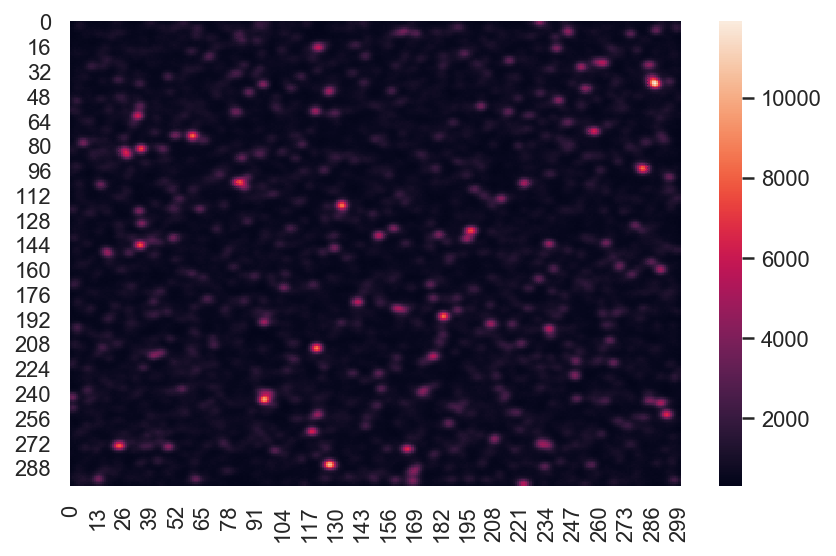

In [21]:
sns.heatmap(data)
plt.tight_layout()

In [22]:
n = 30
w, h = data.shape
ww, hh = w // 30, h // 30
mesh = np.zeros(ww * hh).reshape(ww, hh)

In [23]:
for i in range(ww):
    for j in range(hh):
        mesh[i][j] = np.median(
            sigma_clip(data[i * n : (i + 1) * n, j * n : (j + 1) * n], 3)
        )

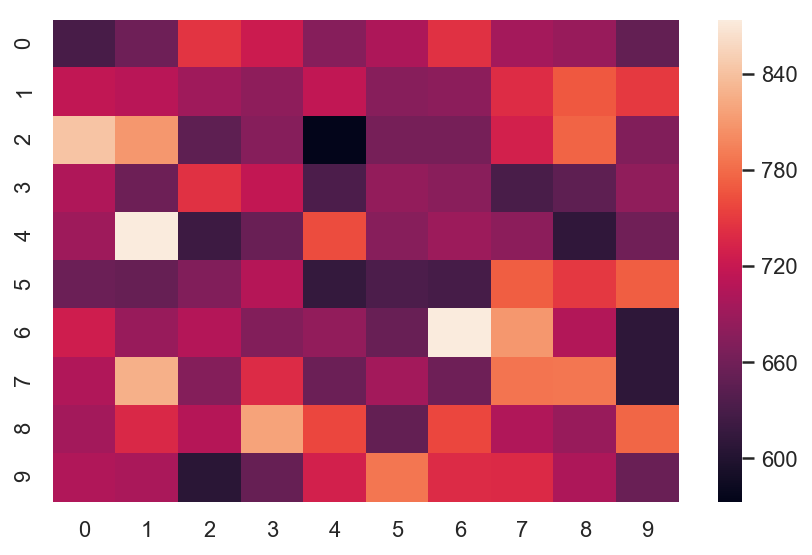

In [24]:
sns.heatmap(mesh)
plt.tight_layout()

## 2σ check

先在四周以边界值扩充 (`‘edge’`)
 
`1`: 超过 2σ，以 median 代替

`0`: 没有超过 2σ，不变

In [32]:
extend_mesh = np.pad(mesh, (1, 1), "edge")

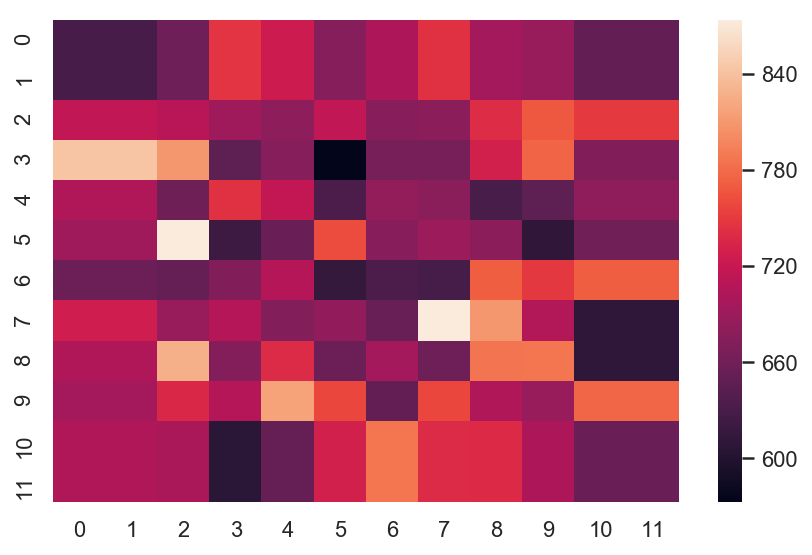

In [33]:
sns.heatmap(extend_mesh)
plt.tight_layout()

In [36]:
sigma_check = np.ones(extend_mesh.shape)
for i in range(1, extend_mesh.shape[0] - 1):
    for j in range(1, extend_mesh.shape[1] - 1):
        median = np.median(extend_mesh[(i - 1) : (i + 1), (j - 1) : (j + 1)])
        sigma = np.std(extend_mesh[(i - 1) : (i + 1), (j - 1) : (j + 1)])
        middle = extend_mesh[i, j]
        sigma_check[i][j] = middle > median + 2 * sigma or middle < median - 2 * sigma
sigma_check = sigma_check[1 : extend_mesh.shape[0] - 1, 1 : extend_mesh.shape[1] - 1]

白色区域即超过 2σ，以 median 代替

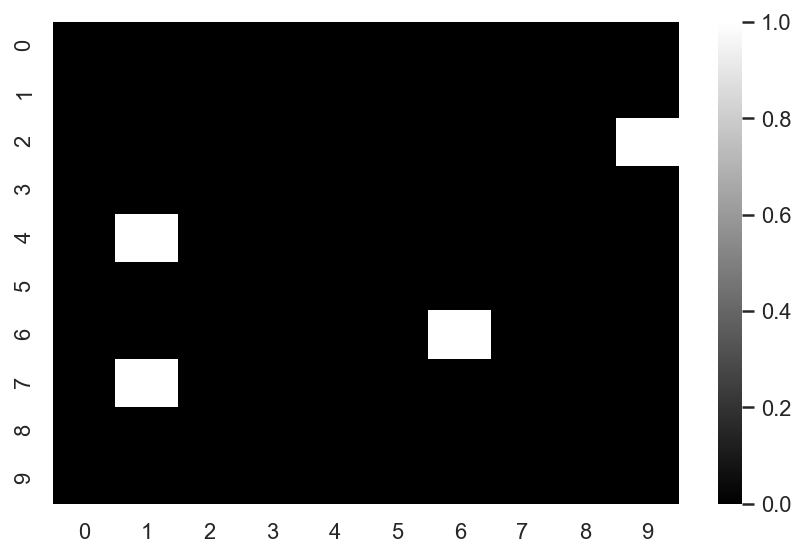

In [38]:
sns.heatmap(sigma_check, cmap="gist_gray")
plt.tight_layout()

## Median Filter
[scipy.ndimage.median_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html#scipy.ndimage.median_filter)

`mode`
The mode parameter determines how the input array is extended when the filter overlaps a border. By passing a sequence of modes with length equal to the number of dimensions of the input array, different modes can be specified along each axis. Default value is `‘reflect’`. The valid values and their behavior is as follows:

`‘reflect’` (d c b a | a b c d | d c b a)

The input is extended by reflecting about the edge of the last pixel.

`‘constant’` (k k k k | a b c d | k k k k)

The input is extended by filling all values beyond the edge with the same constant value, defined by the cval parameter.

`‘nearest’` (a a a a | a b c d | d d d d)

The input is extended by replicating the last pixel.

`‘mirror’` (d c b | a b c d | c b a)

The input is extended by reflecting about the center of the last pixel.

`‘wrap’` (a b c d | a b c d | a b c d)

The input is extended by wrapping around to the opposite edge.

In [39]:
median_filter = ndimage.median_filter(mesh, size=3, mode="nearest")

In [40]:
sigma_median_filter = (1 - sigma_check) * mesh + sigma_check * median_filter

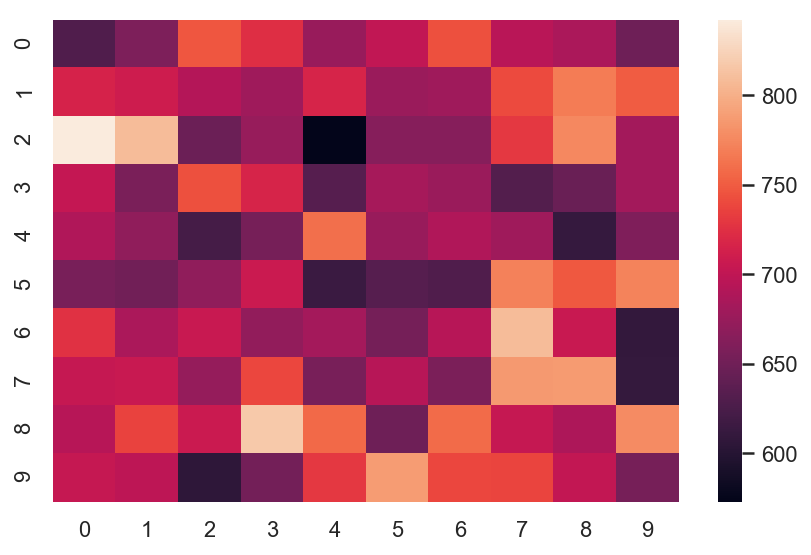

In [146]:
sns.heatmap(sigma_median_filter)
plt.tight_layout()

## Interpolation

[scipy.ndimage.interpolation.zoom](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.interpolation.zoom.html#scipy.ndimage.interpolation.zoom)

`zoom` : float or sequence, optional

 The zoom factor along the axes. If a float, zoom is the same for each axis. If a sequence, zoom should contain one value for each axis.
 
`order` : int, optional

The order of the spline interpolation, default is 3. The order has to be in the range 0-5.
mode : str, optional
Points outside the boundaries of the input are filled according to the given mode (‘constant’, ‘nearest’, ‘reflect’ or ‘wrap’). Default is ‘constant’.

`prefilter` : bool, optional

The parameter prefilter determines if the input is pre-filtered with spline_filter before interpolation (necessary for spline interpolation of order > 1). If False, it is assumed that the input is already filtered. Default is True.


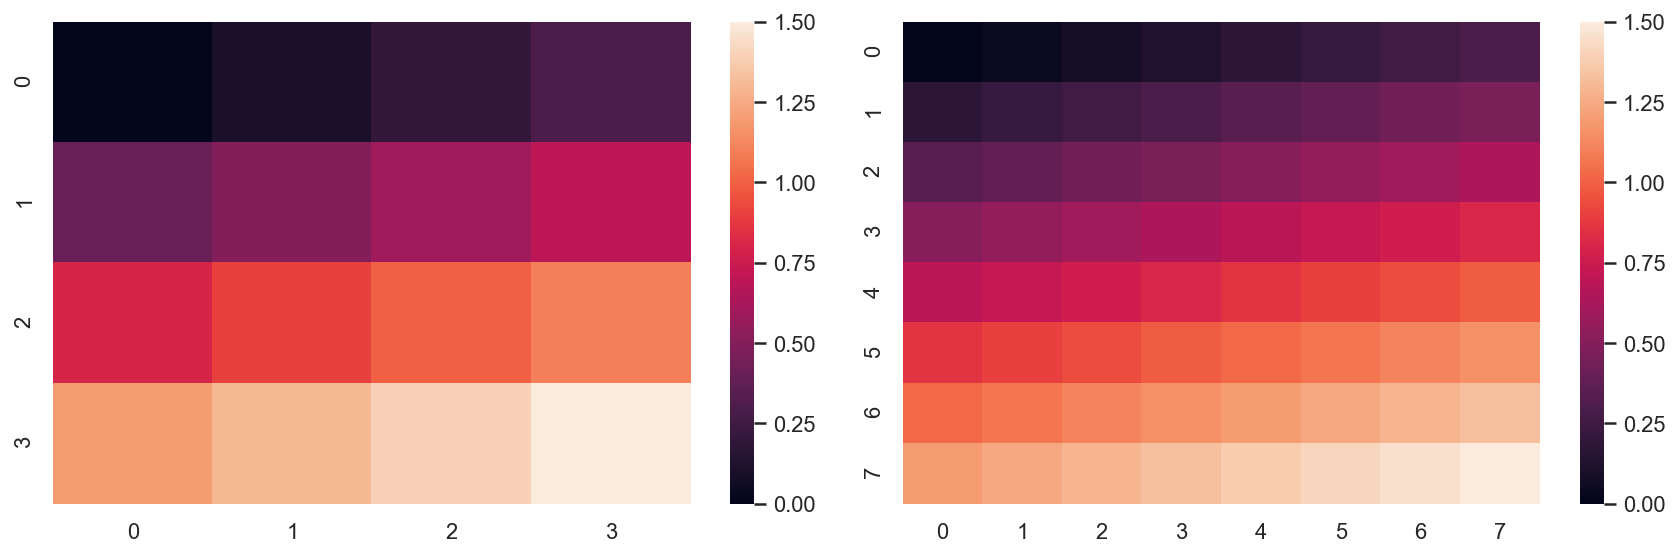

In [147]:
a = np.arange(0, 1.6, 0.1).reshape(4, 4)
b = ndimage.interpolation.zoom(a, zoom=2, order=1, mode="nearest", prefilter=False)
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(a, ax=axes[0])
sns.heatmap(b, ax=axes[1])
plt.tight_layout()

`10 * 10` 线性内插得到 `270 * 270`

In [142]:
interp = ndimage.interpolation.zoom(
    sigma_median_filter, zoom=27, order=1, mode="nearest", prefilter=False
)
interp.shape

(270, 270)

`270 * 270` 四周以边界值扩充成 `300 * 300`

In [144]:
background = np.pad(interp, (15, 15), "edge")
background.shape

(300, 300)

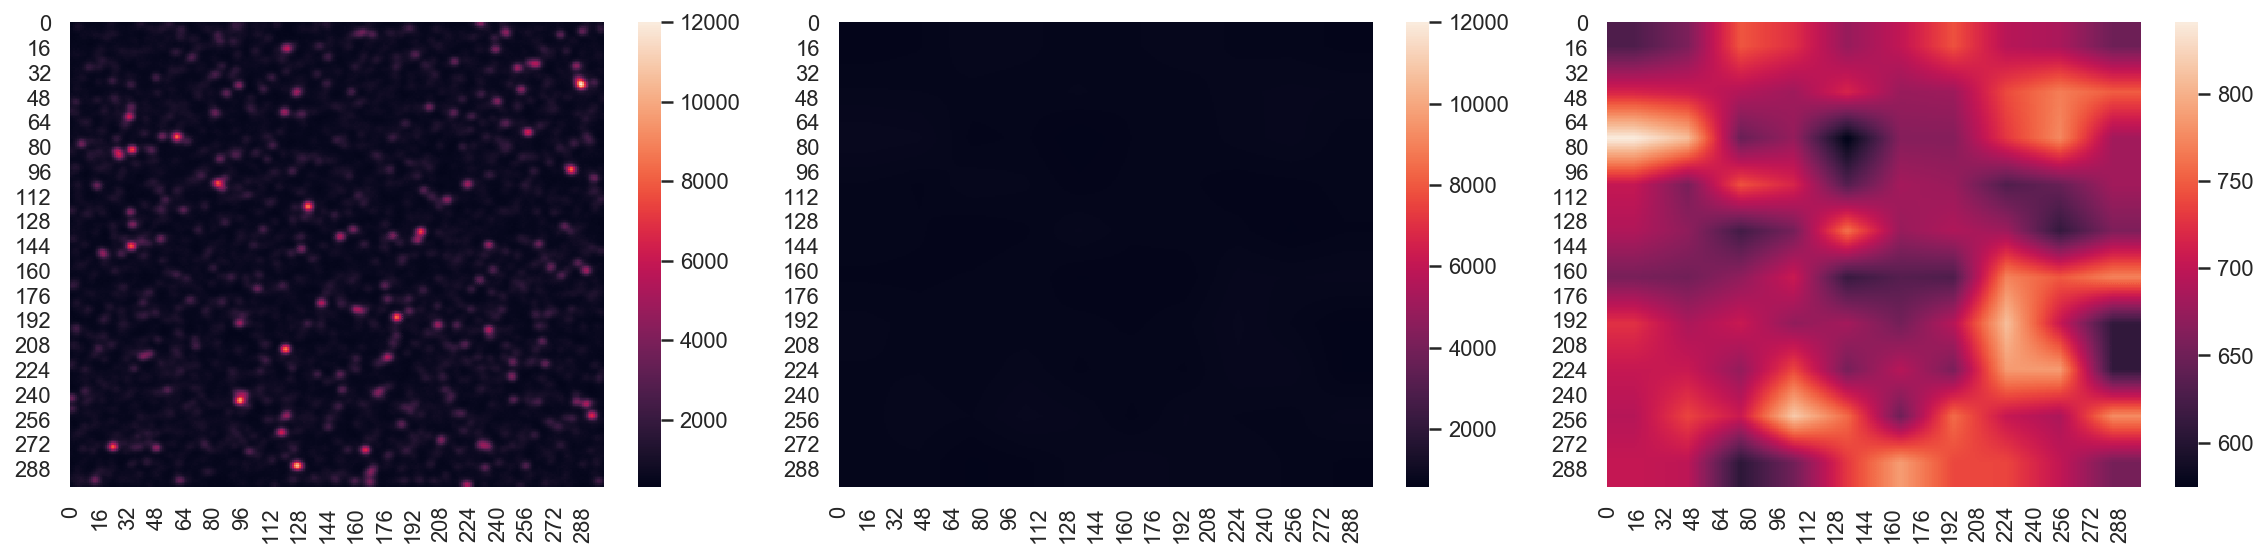

In [150]:
f, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.heatmap(data, ax=axes[0], vmax=12000)
sns.heatmap(background, ax=axes[1], vmax=12000)
sns.heatmap(background, ax=axes[2])
plt.tight_layout()